# Transit Detection with Periodograms

This tutorial demonstrates how to detect transit signals using periodogram analysis. You will learn:

1. How transit detection periodograms work
2. How to use `run_periodogram()` to find periodic signals
3. How to interpret periodogram results
4. The difference between TLS (Transit Least Squares) and LS (Lomb-Scargle) methods
5. How to extract candidate ephemeris from detection results

## Background: Transit Detection

Transiting exoplanets create periodic dips in stellar light curves. Detection algorithms search for these signals by:

1. **Folding** the light curve at many trial periods
2. **Fitting** a transit model (or box model) at each period
3. **Scoring** how well the model matches the data
4. **Identifying** peaks in the score vs period "periodogram"

The two main methods are:
- **BLS/TLS**: Box/Transit Least Squares - optimized for transit-shaped signals
- **Lomb-Scargle (LS)**: Optimized for sinusoidal signals (rotation, pulsations)

## Setup

In [1]:
import numpy as np
import bittr_tess_vetter.api as btv
from bittr_tess_vetter.api import (
    run_periodogram,
    LightCurve,
    Ephemeris,
    Candidate,
    vet_candidate,
)

## Creating Synthetic Transit Data

We will create a light curve with a known transit signal and then try to detect it.

In [2]:
# Set seed for reproducibility
np.random.seed(12345)

# Simulation parameters
TRUE_PERIOD = 4.23  # days - the "true" orbital period
TRUE_T0 = 1800.5    # BTJD - first transit time
TRUE_DURATION_HOURS = 3.0
TRUE_DEPTH_PPM = 800  # 800 ppm = 0.08% depth

# Generate time array: 55 days of TESS data (2 sectors)
cadence_minutes = 2
cadence_days = cadence_minutes / (24 * 60)
time = np.arange(1800, 1855, cadence_days)

# Add a gap simulating the break between sectors
gap_mask = ~((time > 1825) & (time < 1828))
time = time[gap_mask]

print(f"Generated {len(time)} data points spanning {time[-1] - time[0]:.1f} days")
print(f"True signal: P={TRUE_PERIOD} days, depth={TRUE_DEPTH_PPM} ppm")

Generated 37440 data points spanning 55.0 days
True signal: P=4.23 days, depth=800 ppm


In [3]:
def inject_transit(time, period, t0, duration_hours, depth_ppm):
    """Inject a box-shaped transit signal into flux array."""
    flux = np.ones_like(time)
    duration_days = duration_hours / 24.0
    
    # Calculate phase
    phase = ((time - t0) % period) / period
    
    # Find in-transit points (near phase 0 or 1)
    half_dur_phase = (duration_days / 2) / period
    in_transit = (phase < half_dur_phase) | (phase > 1 - half_dur_phase)
    
    # Apply depth
    flux[in_transit] = 1.0 - depth_ppm / 1e6
    
    n_transits = int((time[-1] - time[0]) / period)
    return flux, np.sum(in_transit), n_transits

# Generate transit signal
flux_signal, n_in_transit, n_transits = inject_transit(
    time, TRUE_PERIOD, TRUE_T0, TRUE_DURATION_HOURS, TRUE_DEPTH_PPM
)

# Add noise
noise_ppm = 120  # Typical for a moderately bright TESS target
flux = flux_signal + np.random.normal(0, noise_ppm / 1e6, len(time))
flux_err = np.full_like(flux, noise_ppm / 1e6)

# Estimate SNR
expected_snr = TRUE_DEPTH_PPM / noise_ppm * np.sqrt(n_in_transit)

print(f"Number of transits: ~{n_transits}")
print(f"Points in transit: {n_in_transit}")
print(f"Estimated SNR: {expected_snr:.1f}")

Number of transits: ~13
Points in transit: 1080
Estimated SNR: 219.1


## Running the Periodogram

The `run_periodogram()` function searches for periodic signals in the light curve. Key parameters:

- **method**: `"tls"` (transit search), `"ls"` (sinusoidal), or `"auto"` (TLS for transits)
- **preset**: `"fast"`, `"thorough"`, or `"deep"` - controls search thoroughness
- **min_period**, **max_period**: Search range in days

In [4]:
# Run periodogram with TLS method
result = run_periodogram(
    time=time,
    flux=flux,
    flux_err=flux_err,
    method="tls",        # Transit Least Squares
    preset="fast",       # Fast for quick analysis
    min_period=1.0,      # Search from 1 day
    max_period=20.0,     # to 20 days
)

print("Periodogram Analysis Complete!")
print("=" * 40)

Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 41 durations
Searching 37440 data points, 4135 periods from 1.0 to 19.996 days
Using 1 of 16 CPU threads


Searching for best T0 for period 4.22969 days


Periodogram Analysis Complete!


## Understanding PeriodogramResult

The result contains:
- `best_period`: Strongest detected period
- `best_t0`: Reference epoch for the best period
- `best_duration_hours`: Transit duration (TLS only)
- `snr`: Signal-to-noise ratio
- `peaks`: List of significant peaks found
- `signal_type`: `"transit"` or `"sinusoidal"`

In [5]:
# Examine the main result
print(f"Method: {result.method}")
print(f"Signal type: {result.signal_type}")
print(f"Search range: {result.period_range[0]:.1f} - {result.period_range[1]:.1f} days")
print()
print("Best detection:")
print(f"  Period: {result.best_period:.4f} days")
print(f"  T0: BTJD {result.best_t0:.4f}")
if result.best_duration_hours:
    print(f"  Duration: {result.best_duration_hours:.2f} hours")
if result.snr:
    print(f"  SNR: {result.snr:.1f}")
if result.fap is not None:
    print(f"  FAP: {result.fap:.2e}")

Method: tls
Signal type: transit
Search range: 1.0 - 20.0 days

Best detection:
  Period: 4.2297 days
  T0: BTJD 1800.5017
  Duration: 2.99 hours
  SNR: 168.0
  FAP: 8.00e-05


In [6]:
# Compare detected vs true values
period_error = abs(result.best_period - TRUE_PERIOD)
period_error_pct = period_error / TRUE_PERIOD * 100

print("Detection Accuracy:")
print(f"  True period: {TRUE_PERIOD:.4f} days")
print(f"  Detected period: {result.best_period:.4f} days")
print(f"  Error: {period_error:.4f} days ({period_error_pct:.2f}%)")
print()
if result.best_duration_hours:
    dur_error = abs(result.best_duration_hours - TRUE_DURATION_HOURS)
    print(f"  True duration: {TRUE_DURATION_HOURS:.2f} hours")
    print(f"  Detected duration: {result.best_duration_hours:.2f} hours")
    print(f"  Error: {dur_error:.2f} hours")

Detection Accuracy:
  True period: 4.2300 days
  Detected period: 4.2297 days
  Error: 0.0003 days (0.01%)

  True duration: 3.00 hours
  Detected duration: 2.99 hours
  Error: 0.01 hours


## Examining Multiple Peaks

The periodogram often detects multiple peaks. Some may be:
- **Harmonics**: Multiples of the true period (P/2, P/3, 2P, 3P, etc.)
- **Aliases**: False periods from sampling patterns
- **Real signals**: Multiple planets!

In [7]:
# Look at all detected peaks
print(f"Detected {len(result.peaks)} peaks:")
print("-" * 50)

for i, peak in enumerate(result.peaks):
    # Check if this is a harmonic of the true period
    ratio = peak.period / TRUE_PERIOD
    harmonic = ""
    for mult in [0.5, 1.0, 2.0, 3.0, 0.333, 0.25]:
        if abs(ratio - mult) < 0.05:
            if mult == 1.0:
                harmonic = " <- TRUE PERIOD"
            else:
                harmonic = f" (harmonic: {mult}x true period)"
            break
    
    print(f"Peak {i+1}: P={peak.period:.4f} days, power={peak.power:.2f}{harmonic}")
    if peak.depth_ppm:
        print(f"         depth={peak.depth_ppm:.0f} ppm, SNR={peak.snr or 0:.1f}")

Detected 1 peaks:
--------------------------------------------------
Peak 1: P=4.2297 days, power=28.35 <- TRUE PERIOD
         depth=788 ppm, SNR=168.0


## Visualizing the Phase-Folded Light Curve

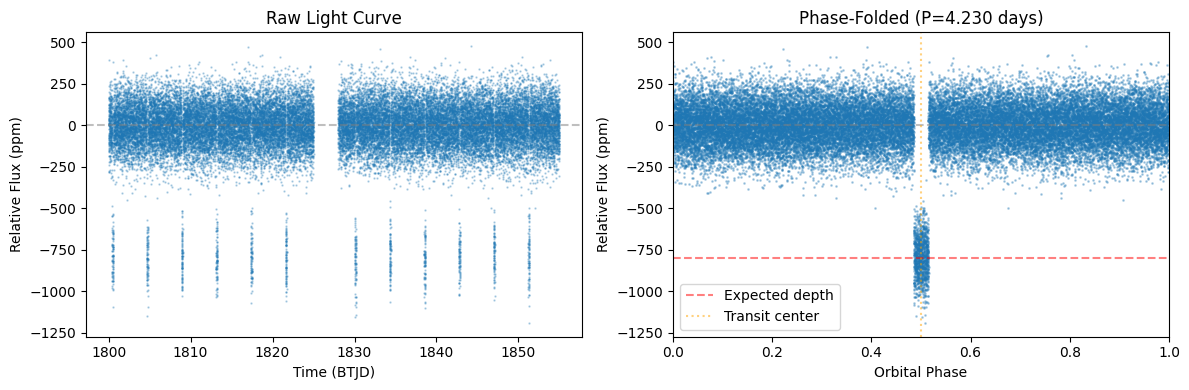

In [8]:
try:
    import matplotlib.pyplot as plt
    
    # Phase-fold the light curve at the detected period
    phase = ((time - result.best_t0) % result.best_period) / result.best_period
    # Shift phase so transit is centered at 0.5
    phase = (phase + 0.5) % 1.0
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Raw light curve
    ax1 = axes[0]
    ax1.scatter(time, (flux - 1) * 1e6, s=0.5, alpha=0.3)
    ax1.set_xlabel('Time (BTJD)')
    ax1.set_ylabel('Relative Flux (ppm)')
    ax1.set_title('Raw Light Curve')
    ax1.axhline(0, color='gray', linestyle='--', alpha=0.5)
    
    # Phase-folded light curve
    ax2 = axes[1]
    ax2.scatter(phase, (flux - 1) * 1e6, s=1, alpha=0.3)
    ax2.set_xlabel('Orbital Phase')
    ax2.set_ylabel('Relative Flux (ppm)')
    ax2.set_title(f'Phase-Folded (P={result.best_period:.3f} days)')
    ax2.axhline(0, color='gray', linestyle='--', alpha=0.5)
    ax2.axhline(-TRUE_DEPTH_PPM, color='red', linestyle='--', alpha=0.5, label='Expected depth')
    ax2.axvline(0.5, color='orange', linestyle=':', alpha=0.5, label='Transit center')
    ax2.legend()
    ax2.set_xlim(0, 1)
    
    plt.tight_layout()
    plt.show()
    
except ImportError:
    print("matplotlib not installed - skipping visualization")

## Creating a Candidate from Periodogram Results

Once you detect a signal, create a `Candidate` for vetting:

In [9]:
# Extract ephemeris from periodogram result
detected_ephemeris = Ephemeris(
    period_days=result.best_period,
    t0_btjd=result.best_t0,
    duration_hours=result.best_duration_hours or 3.0,  # Default if not detected
)

# Get depth from top peak if available
top_peak = result.top_peak
detected_depth_ppm = top_peak.depth_ppm if top_peak and top_peak.depth_ppm else 500

# Create candidate
detected_candidate = Candidate(
    ephemeris=detected_ephemeris,
    depth_ppm=detected_depth_ppm,
)

print("Created candidate from detection:")
print(f"  Period: {detected_candidate.ephemeris.period_days:.4f} days")
print(f"  T0: BTJD {detected_candidate.ephemeris.t0_btjd:.4f}")
print(f"  Duration: {detected_candidate.ephemeris.duration_hours:.2f} hours")
print(f"  Depth: {detected_candidate.depth_ppm:.0f} ppm")

Created candidate from detection:
  Period: 4.2297 days
  T0: BTJD 1800.5017
  Duration: 2.99 hours
  Depth: 788 ppm


In [10]:
# Run vetting on the detected candidate
lc = LightCurve(time=time, flux=flux, flux_err=flux_err)

vetting_result = vet_candidate(
    lc,
    detected_candidate,
    network=False,
)

print("Vetting Results for Detected Candidate:")
print("=" * 40)
for r in vetting_result.results:
    conf = r.confidence
    conf_str = f"{conf:.3f}" if conf is not None else "None"
    print(f"{r.id} {r.name}: confidence={conf_str}")

Vetting Results for Detected Candidate:
V01 Odd-Even Depth: confidence=0.700
V02 Secondary Eclipse: confidence=0.850
V03 Duration Consistency: confidence=0.200
V04 Depth Stability: confidence=0.800
V05 V-Shape: confidence=0.935
V06 Nearby EB Search: confidence=None
V07 ExoFOP TOI Lookup: confidence=None
V08 Centroid Shift: confidence=None
V09 Difference Image: confidence=None
V10 Aperture Dependence: confidence=None
V11 ModShift: confidence=None
V12 SWEET: confidence=None


## Lomb-Scargle Periodogram for Rotation/Variability

The Lomb-Scargle method is designed for sinusoidal signals - useful for detecting stellar rotation or pulsations.

In [11]:
# Create data with sinusoidal variability
np.random.seed(999)

ROTATION_PERIOD = 8.5  # days
VARIABILITY_AMP = 500  # ppm semi-amplitude

# Time array
time_rot = np.arange(1800, 1850, cadence_days)

# Sinusoidal flux variation
flux_rot = 1.0 + (VARIABILITY_AMP / 1e6) * np.sin(2 * np.pi * time_rot / ROTATION_PERIOD)
flux_rot += np.random.normal(0, 100 / 1e6, len(time_rot))
flux_err_rot = np.full_like(flux_rot, 100 / 1e6)

print(f"Created sinusoidal signal with P={ROTATION_PERIOD} days, amp={VARIABILITY_AMP} ppm")

Created sinusoidal signal with P=8.5 days, amp=500 ppm


In [12]:
# Run Lomb-Scargle periodogram
ls_result = run_periodogram(
    time=time_rot,
    flux=flux_rot,
    flux_err=flux_err_rot,
    method="ls",         # Lomb-Scargle for sinusoidal
    preset="fast",
    min_period=1.0,
    max_period=30.0,
)

print(f"LS Periodogram Results:")
print(f"  Method: {ls_result.method}")
print(f"  Signal type: {ls_result.signal_type}")
print(f"  Best period: {ls_result.best_period:.4f} days")
print(f"  True period: {ROTATION_PERIOD} days")
print(f"  Error: {abs(ls_result.best_period - ROTATION_PERIOD):.4f} days")

LS Periodogram Results:
  Method: ls
  Signal type: sinusoidal
  Best period: 8.4948 days
  True period: 8.5 days
  Error: 0.0052 days


## Comparison: TLS vs LS on Transit Signal

Let's see what happens when we apply LS to transit data (spoiler: it's not ideal!):

In [13]:
# Run LS on transit data
ls_on_transit = run_periodogram(
    time=time,
    flux=flux,
    flux_err=flux_err,
    method="ls",
    preset="fast",
    min_period=1.0,
    max_period=20.0,
)

print("LS on Transit Data:")
print(f"  Detected period: {ls_on_transit.best_period:.4f} days")
print(f"  True period: {TRUE_PERIOD} days")
print()
print("Note: LS may find harmonics (P/2) since transits are not sinusoidal!")
print(f"  True period / 2 = {TRUE_PERIOD/2:.4f} days")

LS on Transit Data:
  Detected period: 4.2308 days
  True period: 4.23 days

Note: LS may find harmonics (P/2) since transits are not sinusoidal!
  True period / 2 = 2.1150 days


## Periodogram Presets

The `preset` parameter controls the trade-off between speed and thoroughness:

| Preset | Description | Use Case |
|--------|-------------|----------|
| `fast` | Coarse period grid | Quick exploration, screening |
| `thorough` | Finer grid, more peaks | Standard analysis |
| `deep` | Very fine grid | Publication-quality, faint signals |

In [14]:
# Compare presets (timing)
import time as timer

for preset in ["fast", "thorough"]:
    start = timer.time()
    res = run_periodogram(
        time=time,
        flux=flux,
        flux_err=flux_err,
        method="tls",
        preset=preset,
        min_period=1.0,
        max_period=20.0,
    )
    elapsed = timer.time() - start
    print(f"{preset:10s}: P={res.best_period:.4f} days, n_peaks={len(res.peaks)}, time={elapsed:.2f}s")

Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 41 durations
Searching 37440 data points, 4135 periods from 1.0 to 19.996 days
Using 1 of 16 CPU threads


Searching for best T0 for period 4.22969 days


fast      : P=4.2297 days, n_peaks=1, time=19.71s
Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 41 durations
Searching 37440 data points, 4135 periods from 1.0 to 19.996 days
Using 1 of 16 CPU threads


Searching for best T0 for period 4.22969 days


thorough  : P=4.2297 days, n_peaks=1, time=19.90s


## Multi-Planet Search

For systems with multiple planets, use `max_planets > 1`. This iteratively removes detected signals and searches for additional periods.

In [15]:
# Create a two-planet system
np.random.seed(2024)

PLANET_B_PERIOD = 3.14
PLANET_B_DEPTH = 600
PLANET_C_PERIOD = 7.89
PLANET_C_DEPTH = 400

time_multi = np.arange(1800, 1860, cadence_days)

# Inject two signals
flux_b, _, _ = inject_transit(time_multi, PLANET_B_PERIOD, 1800.2, 2.5, PLANET_B_DEPTH)
flux_c, _, _ = inject_transit(time_multi, PLANET_C_PERIOD, 1801.0, 3.5, PLANET_C_DEPTH)

flux_multi = flux_b + flux_c - 1.0  # Combine (subtract 1 to avoid double-counting baseline)
flux_multi += np.random.normal(0, 80 / 1e6, len(time_multi))
flux_err_multi = np.full_like(flux_multi, 80 / 1e6)

print(f"Two-planet system:")
print(f"  Planet b: P={PLANET_B_PERIOD} days, depth={PLANET_B_DEPTH} ppm")
print(f"  Planet c: P={PLANET_C_PERIOD} days, depth={PLANET_C_DEPTH} ppm")

Two-planet system:
  Planet b: P=3.14 days, depth=600 ppm
  Planet c: P=7.89 days, depth=400 ppm


In [16]:
# Search for multiple planets
multi_result = run_periodogram(
    time=time_multi,
    flux=flux_multi,
    flux_err=flux_err_multi,
    method="tls",
    preset="fast",
    min_period=1.0,
    max_period=15.0,
    max_planets=2,
)

print("Multi-planet search results:")
for i, peak in enumerate(multi_result.peaks[:4]):
    match = ""
    if abs(peak.period - PLANET_B_PERIOD) < 0.1:
        match = " <- Planet b"
    elif abs(peak.period - PLANET_C_PERIOD) < 0.1:
        match = " <- Planet c"
    print(f"  Peak {i+1}: P={peak.period:.3f} days, depth={peak.depth_ppm or 0:.0f} ppm{match}")

Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 39 durations
Searching 43200 data points, 4245 periods from 1.0 to 14.99 days
Using 1 of 16 CPU threads


Searching for best T0 for period 3.14089 days


Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 39 durations
Searching 39938 data points, 4245 periods from 1.0 to 14.99 days
Using 1 of 16 CPU threads


Searching for best T0 for period 7.88903 days


Multi-planet search results:
  Peak 1: P=3.141 days, depth=548 ppm <- Planet b
  Peak 2: P=7.889 days, depth=356 ppm <- Planet c


## Best Practices

1. **Use TLS for transit detection**: LS is for rotation/variability
2. **Watch for harmonics**: Half/double periods are common false positives
3. **Check multiple peaks**: The strongest peak isn't always the true period
4. **Verify with phase-folding**: Always visually inspect the folded light curve
5. **Consider stellar parameters**: Providing stellar_radius and stellar_mass improves TLS

## Summary

In this tutorial, you learned:

- How to use `run_periodogram()` for transit detection
- The difference between TLS (transits) and LS (sinusoidal) methods
- How to interpret `PeriodogramResult` and `PeriodogramPeak` objects
- How to create a `Candidate` from detection results
- About harmonics, aliases, and multi-planet detection

### Next Steps

- **Tutorial 01**: Review basic vetting workflow
- **Tutorial 03**: Learn about pixel-level diagnostics
- Apply to real TESS data from MAST